# 利用cuFFT库进行二维卷积

/home/makerlab/anaconda3/envs/pycuda/lib/python3.8/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')
/tmp/ipykernel_28601/2552341571.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  akshada_blurred[:,:,k] = conv_2d(ker, akshada[:,:,k])
/tmp/ipykernel_28601/2552341571.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  akshada_blurred[:,:,k] = conv_2d(ker, akshada[:,:,k])
/tmp/ipykernel_28601/2552341571.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  akshada_blurred[:,:,k] = conv_2d(ker, akshada[:,:,k])


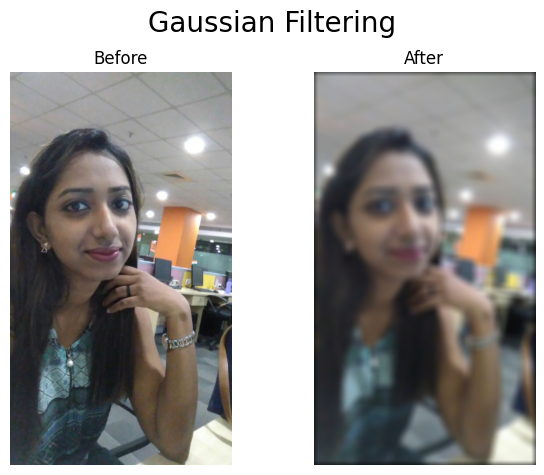

In [1]:
from __future__ import division
import pycuda.autoinit
from pycuda import gpuarray
import numpy as np
from skcuda import fft
from skcuda import linalg
from matplotlib import pyplot as plt


def cufft_conv(x , y):
    
    x = x.astype(np.complex64)
    y = y.astype(np.complex64)
    
    if (x.shape != y.shape):
        return -1
    
    plan = fft.Plan(x.shape, np.complex64, np.complex64)
    inverse_plan = fft.Plan(x.shape, np.complex64, np.complex64)
    
    x_gpu = gpuarray.to_gpu(x)
    y_gpu = gpuarray.to_gpu(y)
    
    x_fft = gpuarray.empty_like(x_gpu, dtype=np.complex64)
    y_fft = gpuarray.empty_like(y_gpu, dtype=np.complex64)
    out_gpu = gpuarray.empty_like(x_gpu, dtype=np.complex64)
    
    fft.fft(x_gpu, x_fft, plan)
    fft.fft(y_gpu, y_fft, plan)
    
    
    linalg.multiply(x_fft, y_fft, overwrite=True)
    
    fft.ifft(y_fft, out_gpu, inverse_plan, scale=True)
    
    conv_out = out_gpu.get()
    
    return conv_out


def conv_2d(ker, img):
    
    padded_ker = np.zeros( (img.shape[0] + 2*ker.shape[0],  img.shape[1] + 2*ker.shape[1] )).astype(np.float32)
    
    padded_ker[:ker.shape[0], :ker.shape[1]] = ker
    
    padded_ker = np.roll(padded_ker, shift=-ker.shape[0]//2, axis=0)
    padded_ker = np.roll(padded_ker, shift=-ker.shape[1]//2, axis=1)
    
    padded_img = np.zeros_like(padded_ker).astype(np.float32)
    
    padded_img[ker.shape[0]:-ker.shape[0], ker.shape[1]:-ker.shape[1]] = img
    
    out_ = cufft_conv(padded_ker, padded_img)
    
    output = out_[ker.shape[0]:-ker.shape[0], ker.shape[1]:-ker.shape[1]]
    
    return output

gaussian_filter = lambda x, y, sigma : (1 / np.sqrt(2*np.pi*(sigma**2)) )*np.exp( -(x**2 + y**2) / (2 * (sigma**2) ))

def gaussian_ker(sigma):
    ker_ = np.zeros((2*sigma+1, 2*sigma+1))
    
    for i in range(2*sigma + 1):
        for j in range(2*sigma + 1):
            ker_[i,j] = gaussian_filter(i - sigma, j - sigma, sigma)
            
    total_ = np.sum(ker_.ravel())
    
    ker_ = ker_ / total_
    
    return ker_


if __name__ == '__main__':
    
    akshada = np.float32(plt.imread('akshada.jpg')) / 255
    akshada_blurred = np.zeros_like(akshada)
    ker = gaussian_ker(15)
    
    for k in range(3):
        akshada_blurred[:,:,k] = conv_2d(ker, akshada[:,:,k])
    
    
    fig, (ax0, ax1) = plt.subplots(1,2)
    fig.suptitle('Gaussian Filtering', fontsize=20)
    ax0.set_title('Before')
    ax0.axis('off')
    ax0.imshow(akshada)
    ax1.set_title('After')
    ax1.axis('off')
    ax1.imshow(akshada_blurred)
    plt.tight_layout()
    plt.subplots_adjust(top=.85)
    plt.show()